# Counting Objects in Multiple Zones




---
This is the more advanced cookbook on counting objects in <u>multiple zones</u>. To learn how to count objects in a single zone, check out [Count Objects in a Zone](https://supervision.roboflow.com/develop/notebooks/)!

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit -> Notebook settings -> Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Feb 25 17:51:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install required packages

In [2]:
!pip install -q ultralytics supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.1 MB/s eta 0:00:00


# Imports

In [3]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

# Download a Supervision video asset

In [ ]:
path_to_video = download_assets(VideoAssets.MARKET_SQUARE)

# Use Supervision to save the first frame of the video to draw the polygons.

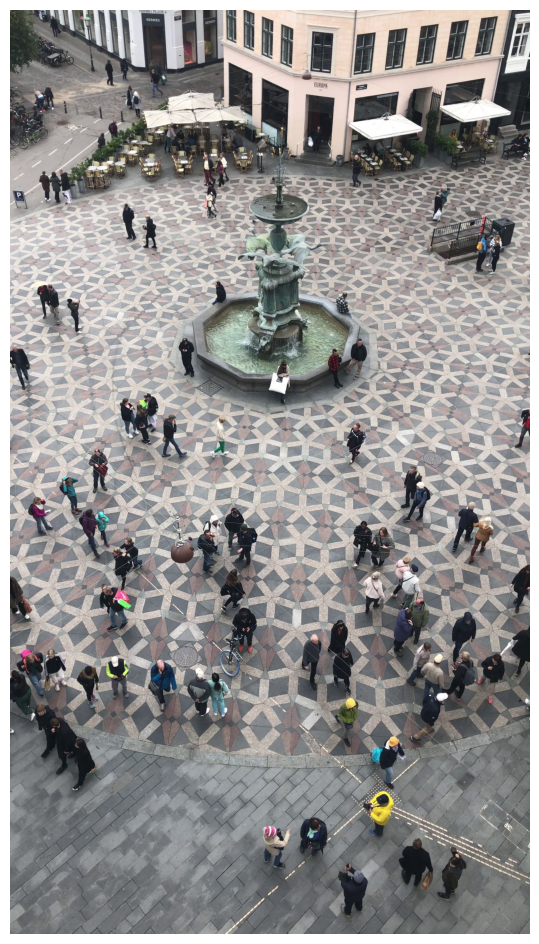

In [5]:
generator = sv.get_video_frames_generator(path_to_video)
frame = next(generator)
sv.plot_image(frame, (12, 12))

# Run Object Detection
Let's start by running the detection model on the first frame and annotating the results. In this cookbook, we use [Ultralytics](https://github.com/ultralytics/ultralytics) YOLOv8, but it can be successfully replaced with [other models](https://supervision.roboflow.com/latest/detection/core/).

We initiate the model and perform detection on the first frame of the video. Then, we convert the result into a [sv.Detections](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [6]:
model = YOLO("yolov8x.pt")

results = model(frame)[0]
detections = sv.Detections.from_ultralytics(results)

100%|██████████| 131M/131M [00:00<00:00, 155MB/s]



0: 640x384 55 persons, 1 bicycle, 1 bench, 244.9ms
Speed: 11.2ms preprocess, 244.9ms inference, 1273.1ms postprocess per image at shape (1, 3, 640, 384)


The results we've obtained can be easily visualized with [sv.BoundingBoxAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator). By default, this annotator uses the same color to highlight objects of the same category. However, with the integration of a [tracker](https://supervision.roboflow.com/latest/trackers/), it becomes possible to assign unique colors to each tracked object. We can easily define our own [color palettes](https://supervision.roboflow.com/latest/draw/color/#supervision.draw.color.ColorPalette) and adjust parameters such as line thickness, allowing for a highly tailored visualization experience.

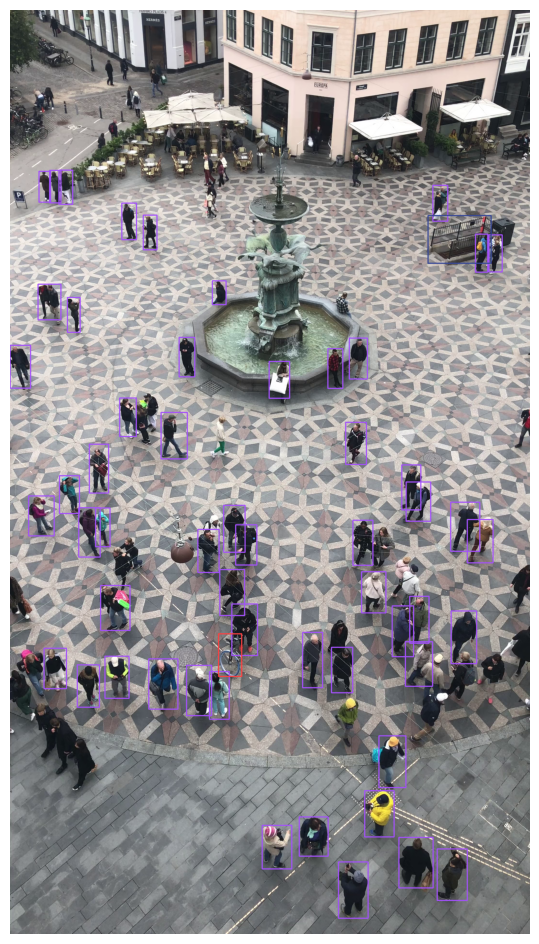

In [7]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

# Improve Visualizations

Supervision annotators can be easily combined with one another. Let's enhance our visualization by adding [sv.LabelAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.PolygonAnnotator.annotate), which we will use to mark detections with a label indicating their category and confidence level.

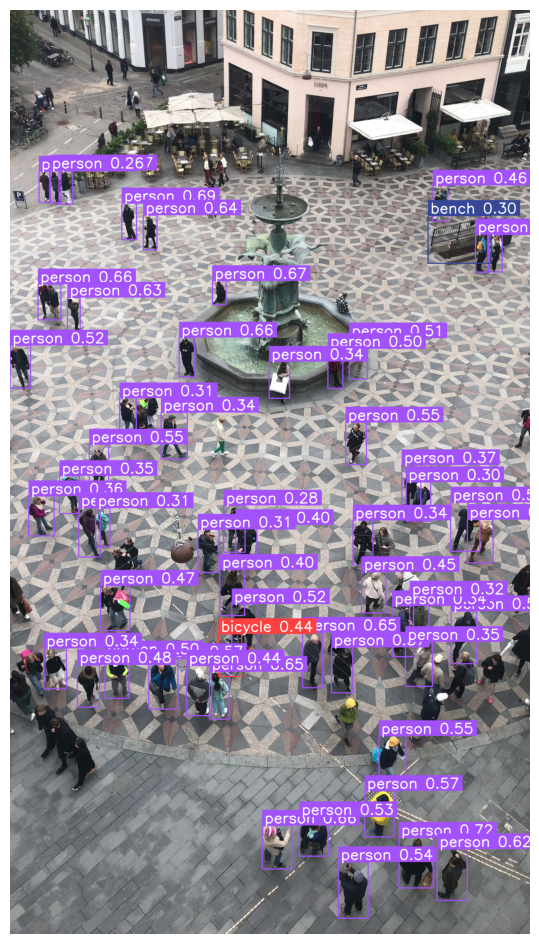

In [40]:
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

# Define polygons.

We can use [VideoInfo.from_video_path](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [10]:
w, h = sv.VideoInfo.from_video_path(path_to_video).resolution_wh
print(w,h)

2160 3840


With a known height and width, we can create a zone in the middle 4th of the screen. You can also use [PolygonZone](https://roboflow.github.io/polygonzone/), which enables you to draw your own polygons on an image and get the exact NumPy points.

In [41]:
polygons = [np.array([[0, 0], [0, h/2], [w/2, h/2], [w/2, 0]], dtype=np.int32), #Top left polygon
            np.array([[0, h/2], [0, h], [w/2, h], [w/2, h/2]], dtype=np.int32), #Top right polygon
            np.array([[w/2, 0], [w/2, h/2], [w, h/2], [w, 0]], dtype=np.int32), #Bottom left polygon
            np.array([[w/2, h/2], [w/2, h], [w, h], [w, h/2]], dtype=np.int32)] #Bottom right polygon

# Initatiate Polygon Zones and Annotators

The polygons we've created can be visualized using [sv.PolygonZone](https://supervision.roboflow.com/latest/detection/tools/polygon_zone/). This tool also allows for polygons to be displayed on the video.

The count of each people in each polygon will be displayed using [sv.PolygonZoneAnnotator](https://supervision.roboflow.com/latest/detection/tools/polygon_zone/#polygonzoneannotator).

We will create create 3 lists (zones, zone_annotators, and box_annotators) that will hold corresponding values for each region.


In [14]:
#Create zones, zone_annotator, and box_annotator based on polygon zone of interest

video_info = sv.VideoInfo.from_video_path(path_to_video)

#Zones
zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh,
    )
    for polygon
    in polygons
]

colors = sv.ColorPalette.DEFAULT #Returns a default color palette.

#Zone Annotators
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]

#Box Annotators
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))]

# Process Video

All the operations we plan to perform for each frame of our video - detection, annotation, and counting - are encapsulated in a function named callback.

In [37]:
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    #imgsz=1280 sets the image size for YOLO model input, balancing detail retention and computational efficiency
    #setting verbose equal to false will mute detection outputs of the model
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[detections.class_id == 0] #since we are only worried about the first class, which is "person"

    labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)]

    frame = label_annotator.annotate(frame, detections, labels)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        zone.trigger(detections=detections)
        frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

In [38]:
SOURCE_VIDEO_PATH = "market-square.mp4"
TARGET_VIDEO_PATH = "output-market.mp4"

Finally, we are ready to process our entire video. We will use [sv.process_video](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.process_video) and pass to it the previously defined SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, and `callback`.

In [39]:
sv.process_video(SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, callback = callback)